In [36]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import os
import numpy as np
import pandas as pd
import pickle
from backtesting import Backtest, Strategy
from backtesting.lib import resample_apply
import matplotlib.pyplot as plt

In [37]:
data = pd.read_csv(
    os.path.join(os.path.abspath(''), '..', '..', 'data', "BTCUSDT-1m-2024-01.csv"),
    usecols = [0,1,2,3,4]
)
# data["date"] = pd.to_datetime(data["date"], unit="ms")
data.columns = ["Date", "Open", "High", "Low", "Close"]
data["Date"] = pd.to_datetime(data["Date"], unit="ms")
data.set_index("Date", inplace=True)

In [38]:
data

,Open,High,Low,Close
Date,,,,
2024-01-01 00:01:00,42298.62,42320.00,42298.61,42320.00
2024-01-01 00:02:00,42319.99,42331.54,42319.99,42325.50
2024-01-01 00:03:00,42325.50,42368.00,42325.49,42367.99
2024-01-01 00:04:00,42368.00,42397.23,42367.99,42397.23
2024-01-01 00:05:00,42397.22,42409.20,42385.26,42409.20
...,...,...,...,...
2024-01-31 23:55:00,42611.31,42614.98,42607.91,42614.98
2024-01-31 23:56:00,42614.98,42617.80,42610.55,42617.80
2024-01-31 23:57:00,42617.80,42617.80,42617.79,42617.80


Strategy Class

In [39]:
class MomentumStrategy(Strategy):
    small_threshold = 0
    large_threshold = 3
    def momentum(self, data):
        return data.pct_change(periods=7).to_numpy() * 100
    def init(self):
        self.pct_change_long = resample_apply("2h", self.momentum, self.data.Close.s)
        self.pct_change_short = resample_apply("30T", self.momentum, self.data.Close.s)
    def next(self):
        change_long = self.pct_change_long[-1]
        change_short = self.pct_change_short[-1]
        if self.position:
            # check whether we should close
            if self.position.is_long and change_short < self.small_threshold:
                self.position.close()
            elif self.position.is_short and change_short > -1 * self.small_threshold:
                self.position.close()
        else:
            # check whether we should go long / short
            if change_long > self.large_threshold and change_long > self.small_threshold:
                self.buy()
            elif change_long < -1 * self.large_threshold and change_short < -1 * self.small_threshold:
                self.sell()

Test Run

In [40]:
bt = Backtest(data[data.index < "2024-02-01"], MomentumStrategy, cash=10_000_000, commission=0.002)
stats = bt.run()
# bt.optimize(
#     small_threshold = list(np.arange(0, 1, 0.1)),
#     large_threshold = list(np.arange(1, 3, 0.2)),
#     maximize= "Equity Final [$]"
# )
bt.plot(resample=False)

Row(id='3967', ...)

In [41]:
stats

Start                     2024-01-01 00:01:00
End                       2024-01-31 23:59:00
Duration                     30 days 23:58:00
Exposure Time [%]                   12.338986
Equity Final [$]                 3552505.9658
Equity Peak [$]                10400636.26024
Return [%]                          -64.47494
Buy & Hold Return [%]                0.614367
Return (Ann.) [%]                  -99.999552
Volatility (Ann.) [%]                0.000946
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -65.843378
Avg. Drawdown [%]                   -2.974187
Max. Drawdown Duration       29 days 20:16:00
Avg. Drawdown Duration        1 days 06:09:00
# Trades                                  543
Win Rate [%]                         1.841621
Best Trade [%]                       3.506361
Worst Trade [%]                      -1.57603
Avg. Trade [%]                    

In [42]:
stats._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,228,1200,1830,43693.92342,45225.99,349311.18024,0.035064,2024-01-01 20:01:00,2024-01-02 06:31:00,0 days 10:30:00
1,228,1831,1832,45309.30774,45215.41,-21408.68472,-0.002072,2024-01-02 06:32:00,2024-01-02 06:33:00,0 days 00:01:00
2,227,1833,1834,45303.58632,45204.28,-22542.53464,-0.002192,2024-01-02 06:34:00,2024-01-02 06:35:00,0 days 00:01:00
3,227,1835,1836,45317.00310,45239.40,-17615.90370,-0.001712,2024-01-02 06:36:00,2024-01-02 06:37:00,0 days 00:01:00
4,226,1837,1838,45343.47594,45225.72,-26612.84244,-0.002597,2024-01-02 06:38:00,2024-01-02 06:39:00,0 days 00:01:00
...,...,...,...,...,...,...,...,...,...,...
538,82,42111,42112,43440.70800,43358.81,-6715.63600,-0.001885,2024-01-30 05:52:00,2024-01-30 05:53:00,0 days 00:01:00
539,82,42113,42114,43453.45344,43368.39,-6975.20208,-0.001958,2024-01-30 05:54:00,2024-01-30 05:55:00,0 days 00:01:00
540,82,42115,42116,43455.12678,43360.55,-7755.29596,-0.002176,2024-01-30 05:56:00,2024-01-30 05:57:00,0 days 00:01:00
541,82,42117,42118,43433.01264,43365.04,-5573.75648,-0.001565,2024-01-30 05:58:00,2024-01-30 05:59:00,0 days 00:01:00


In [43]:
stats._equity_curve

,Equity,DrawdownPct,DrawdownDuration
2024-01-01 00:01:00,1.000000e+07,0.000000,NaT
2024-01-01 00:02:00,1.000000e+07,0.000000,NaT
2024-01-01 00:03:00,1.000000e+07,0.000000,NaT
2024-01-01 00:04:00,1.000000e+07,0.000000,NaT
2024-01-01 00:05:00,1.000000e+07,0.000000,NaT
...,...,...,...
2024-01-31 23:55:00,3.552506e+06,0.658434,NaT
2024-01-31 23:56:00,3.552506e+06,0.658434,NaT
2024-01-31 23:57:00,3.552506e+06,0.658434,NaT
2024-01-31 23:58:00,3.552506e+06,0.658434,NaT


Walk forward

In [44]:
def walk_forward(
    strategy,
    data_full,
    warmup_bars,
    lookback_bars,
    validation_bars,
    cash=10_000_000,
    commission=0.002
):
    stats_master = []
    for i in range(lookback_bars + warmup_bars, len(data_full) - validation_bars, validation_bars):
        training_data = data_full.iloc[i - lookback_bars - warmup_bars:i]
        validation_data = data_full.iloc[i - warmup_bars:i + validation_bars]
        bt_training = Backtest(training_data, strategy, cash=cash, commission=commission)
        # stats_training = bt.optimize(
        #                         small_threshold = list(np.arange(0, 1, 0.1)),
        #                         large_threshold = list(np.arange(1, 3, 0.2)),
        #                         maximize= "Equity Final [$]"
        #                     )
        stats_training = bt.run()
        small_threshold = 0.5
        large_threshold = 2
        bt_validation = Backtest(validation_data, strategy, cash=cash, commission=commission)
        stats_validation = bt_validation.run(
            small_threshold = small_threshold,
            large_threshold = large_threshold
        )
        stats_master.append(stats_validation)
    return stats_master

In [45]:
lookback_bars = 20 * 1440
validation_bars = 10 * 1440
warmup_bars = 16 * 60
stats = walk_forward(MomentumStrategy, data_full=data, lookback_bars=lookback_bars, validation_bars=validation_bars, warmup_bars=warmup_bars)

In [46]:
strategy_return = [x["Return [%]"] for x in stats]
hold_return = [x["Buy & Hold Return [%]"] for x in stats] 
print(strategy_return)
print(hold_return)

[-56.714001326199984]
[4.091669956478487]


Plot

Plot stats of particular result

In [47]:
def plot_stats(data_full, stats):
    equity_curve = stats._equity_curve
    aligned_data = data_full.reindex(equity_curve.index)
    bt = Backtest(aligned_data, MomentumStrategy, cash=10_000_000, commission=0.002)
    bt.plot(results=stats, resample=False)

In [48]:
plot_stats(data, stats[0])

Plot full equity curve of all validation

In [49]:
def plot_full_equity_curve(
        data,
        stats_list,
        warmup_bars,
        lookback_bars
):
    equity_curves = [x["_equity_curve"].iloc[warmup_bars:] for x in stats_list] 
    combined = pd.Series()
    for curve in equity_curves:
        if len(combined) == 0:
            combined = curve["Equity"]/1e7
        else:
            combined = pd.concat([combined, (curve["Equity"]/1e7) * combined.iloc[-1]])
    aligned_price_data = data[data.index <= combined.index[-1]].iloc[lookback_bars + warmup_bars:]
    fig, ax1 = plt.subplots()
    ax1.plot(combined.index, combined, color = "orange")
    ax2 = ax1.twinx()
    ax2.plot(aligned_price_data.index, aligned_price_data.Close)
    plt.show()
#     print(combined)

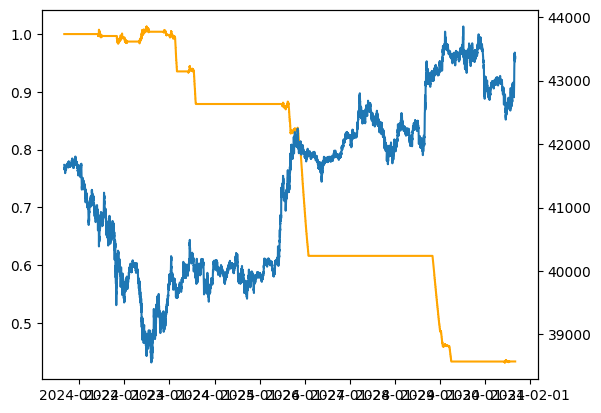

In [50]:
plot_full_equity_curve(data, stats, warmup_bars=warmup_bars, lookback_bars=lookback_bars)

In [53]:
def plot_flow_graph(
        data_full,
        lookback_bars,
        validation_bars
):
    ranges = list(range(lookback_bars + warmup_bars, len(data_full) - validation_bars, validation_bars))
    for i in range(len(ranges)):
        training_data = data_full.iloc[ranges[i] - lookback_bars :ranges[i]]
        validation_data = data_full.iloc[ranges[i] :ranges[i] + validation_bars]
        plt.fill_between(training_data.index, 
                         [len(ranges) - i - 0.5] * len(training_data.index),
                         [len(ranges) - i + 0.5] * len(training_data.index),
                         color="blue"
                         )
        plt.fill_between(validation_data.index, 
                         [len(ranges) - i - 0.5] * len(validation_data.index),
                         [len(ranges) - i + 0.5] * len(validation_data.index),
                         color="orange"
                         )
    plt.show()

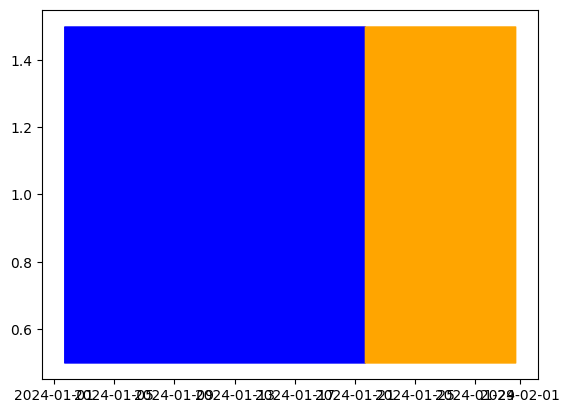

In [54]:
plot_flow_graph(data, lookback_bars, validation_bars)